In [1]:
from fastai import *
from fastai.vision import *
import torch.onnx
from torch.autograd import Variable
import scipy.stats as stats
import netron

In [2]:
import os

os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

In [3]:
path = untar_data(URLs.CIFAR_100)
# path = Path('data/CCSN/')

In [4]:
data = (
    (
        ImageList.from_folder(path)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(get_transforms(), size=128)
    )
    .databunch(bs=64)
    .normalize(imagenet_stats)
)

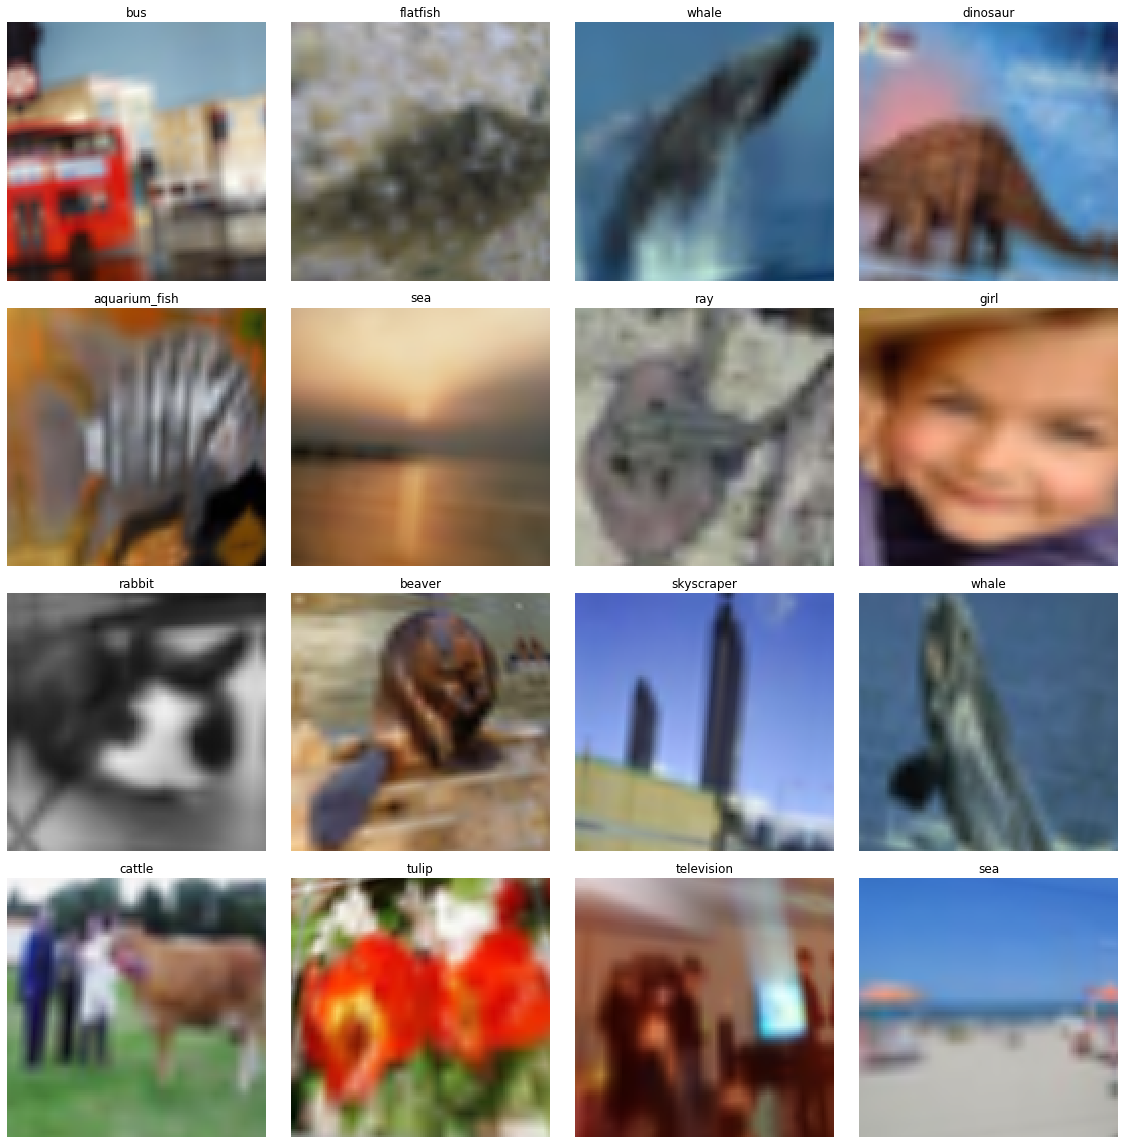

In [5]:
data.show_batch(4)

In [6]:
data.c

100

In [7]:
data

ImageDataBunch;

Train: LabelList (48000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
cloud,cloud,cloud,cloud,cloud
Path: /home/subhaditya/.fastai/data/cifar100;

Valid: LabelList (12000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
whale,tank,streetcar,crocodile,bee
Path: /home/subhaditya/.fastai/data/cifar100;

Test: None

# LeNet

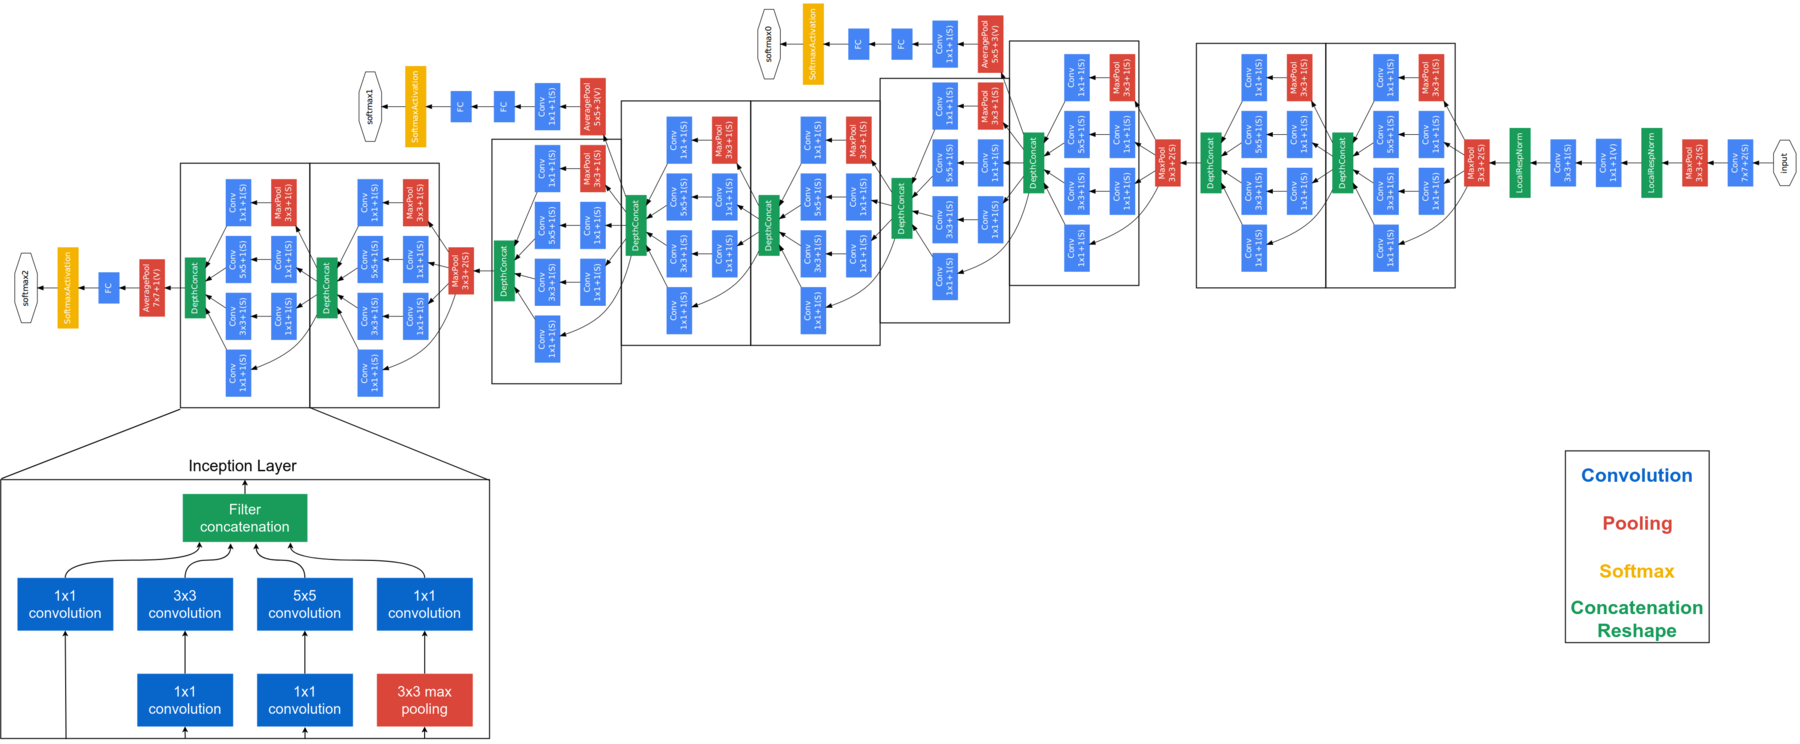

In [8]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [9]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes=100, conv_block=None):
        super(InceptionAux, self).__init__()
        conv_block = BasicConv2d
        self.conv = conv_block(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.adaptive_avg_pool2d(x, (4, 4))
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x, inplace=True)
        x = F.dropout(x, 0.7)
        x = self.fc2(x)
        return x

In [10]:
class Inception(nn.Module):
    def __init__(
        self,
        in_channels,
        ch1x1,
        ch3x3red,
        ch3x3,
        ch5x5red,
        ch5x5,
        pool_proj,
        conv_block=None,
    ):
        super(Inception, self).__init__()
        conv_block = BasicConv2d
        self.branch1 = conv_block(in_channels, ch1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            conv_block(in_channels, ch3x3red, kernel_size=1),
            conv_block(ch3x3red, ch3x3, kernel_size=3, padding=1),
        )
        self.branch3 = nn.Sequential(
            conv_block(in_channels, ch5x5red, kernel_size=1),
            conv_block(ch5x5red, ch5x5, kernel_size=3, padding=1),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            conv_block(in_channels, pool_proj, kernel_size=1),
        )

    def forward(self, x):
        outputs = [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)]
        return torch.cat(outputs, 1)

In [11]:
class Model(nn.Module):
    __constants__ = ["aux_logits", "transform_input"]

    def __init__(
        self,
        num_classes=100,
        aux_logits=True,
        transform_input=False,
        init_weights=True,
        blocks=None,
    ):
        super(Model, self).__init__()
        conv_block = BasicConv2d
        inception_block = Inception
        inception_aux_block = InceptionAux

        self.aux_logits = aux_logits
        self.transform_input = transform_input
        self.maxpool = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.conv1 = conv_block(3, 64, kernel_size=7, stride=2, padding=3)

        self.conv2 = conv_block(64, 64, kernel_size=1)
        self.conv3 = conv_block(64, 192, kernel_size=3, padding=1)

        #                                  in_channels,ch1x1,ch3x3red,ch3x3,ch5x5red,ch5x5,pool_proj
        self.inception3a = inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = inception_block(256, 128, 128, 192, 32, 96, 64)

        self.inception4a = inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = inception_block(528, 256, 160, 320, 32, 128, 128)

        self.inception5a = inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = inception_block(832, 384, 192, 384, 48, 128, 128)
        self.aux1 = inception_aux_block(512, num_classes)
        self.aux2 = inception_aux_block(528, num_classes)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(1024, num_classes)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):

                X = stats.truncnorm(-2, 2, scale=0.01)
                values = torch.as_tensor(X.rvs(m.weight.numel()), dtype=m.weight.dtype)
                values = values.view(m.weight.size())
                with torch.no_grad():
                    m.weight.copy_(values)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)
        x = self.inception4a(x)
        aux1 = self.aux1(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        aux2 = self.aux2(x)

        x = self.inception4e(x)
        x = self.maxpool(x)
        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        #         return x, aux2, aux1

        return x

In [12]:
learn = None
gc.collect()

35372

In [13]:
learn = Learner(
    data,
    Model(),
    metrics=[accuracy, error_rate],
    opt_func=AdamW,
    callback_fns=ShowGraph,
).to_fp16()

In [56]:
learn.summary()

Model
Layer (type)         Output Shape         Param #    Trainable 
MaxPool2d            [832, 4, 4]          0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
Conv2d               [64, 32, 32]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
Conv2d               [192, 32, 32]        110,592    True      
______________________________________________________________________
BatchNorm2d          [192, 32, 32]        384        True      
________________________________________________________

In [14]:
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


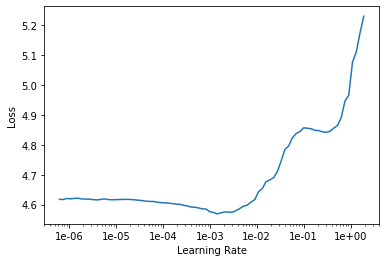

In [57]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.463567,3.346503,0.195583,0.804417,04:25


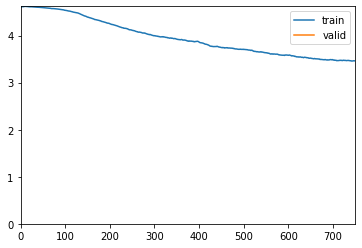

In [15]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.977549,3.839381,0.121667,0.878333,01:24
1,3.383994,3.274186,0.200583,0.799417,01:03
2,2.800417,2.715525,0.302167,0.697833,01:03
3,2.279535,2.243757,0.404167,0.595833,01:04
4,1.949257,1.921993,0.477000,0.523000,01:04
5,1.682176,1.656914,0.536250,0.463750,01:04
6,1.450515,1.475203,0.588000,0.412000,01:04
7,1.261565,1.360547,0.615250,0.384750,01:04
8,1.143017,1.292919,0.632000,0.368000,01:04
9,1.105887,1.279854,0.632583,0.367417,01:05


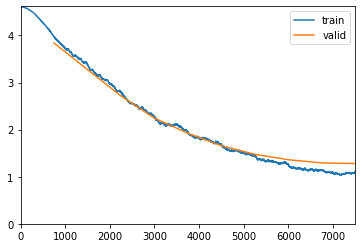

In [58]:
learn.fit_one_cycle(10, 1e-4)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


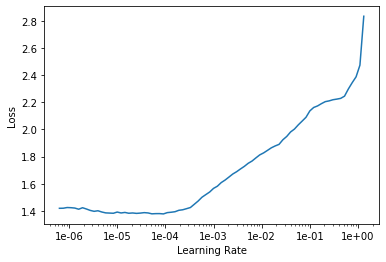

In [20]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.062679,1.279491,0.636333,0.363667,01:02
1,1.059840,1.281249,0.632083,0.367917,01:02
2,1.066836,1.279322,0.634417,0.365583,01:02
3,1.023021,1.272006,0.637750,0.362250,01:03
4,0.988335,1.252880,0.645250,0.354750,01:03
5,0.954135,1.236477,0.645500,0.354500,01:03
6,0.896463,1.226984,0.647667,0.352333,01:02
7,0.889333,1.216911,0.649750,0.350250,01:04
8,0.870749,1.210298,0.652167,0.347833,01:04
9,0.877148,1.216879,0.650833,0.349167,01:04


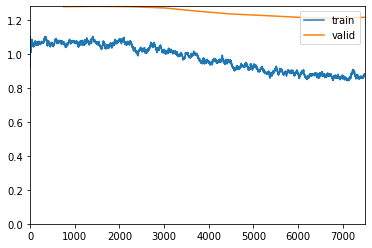

In [59]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.881750,1.236750,0.649083,0.350917,01:03
1,0.976225,1.306328,0.632250,0.367750,01:04
2,1.121447,1.415723,0.608667,0.391333,01:04
3,1.257696,1.534094,0.572583,0.427417,01:05
4,1.305208,1.576021,0.571750,0.428250,01:04
5,1.258478,1.496713,0.588333,0.411667,01:04
6,1.222473,1.577989,0.573500,0.426500,01:04
7,1.108174,1.417714,0.601583,0.398417,01:04
8,0.996616,1.355265,0.622583,0.377417,01:04
9,0.933717,1.255249,0.650333,0.349667,01:04


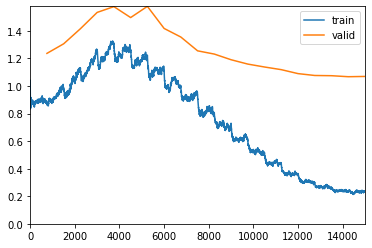

In [60]:
learn.unfreeze()
learn.fit_one_cycle(20, 1e-4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.246220,1.086109,0.712917,0.287083,01:02
1,0.303231,1.171807,0.698583,0.301417,01:03
2,0.395569,1.268704,0.676917,0.323083,01:03
3,0.528749,1.359218,0.659000,0.341000,01:03
4,0.645821,1.331079,0.667083,0.332917,01:04
5,0.692793,1.444732,0.636167,0.363833,01:03
6,0.656179,1.433933,0.639167,0.360833,01:03
7,0.593761,1.370873,0.647917,0.352083,01:03
8,0.554747,1.343091,0.657583,0.342417,01:05


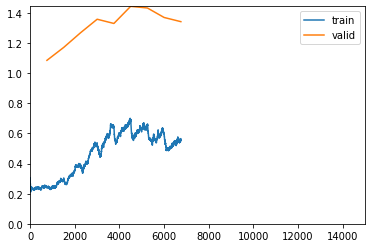

KeyboardInterrupt: 

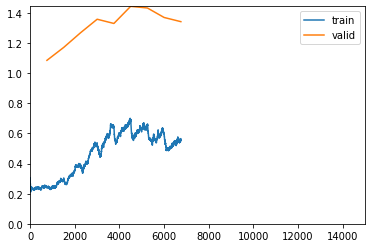

In [61]:
learn.unfreeze()
learn.fit_one_cycle(20, 1e-4)

In [ ]:
learn.save('stage-1')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, 1e-4)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(50, 1e-4)

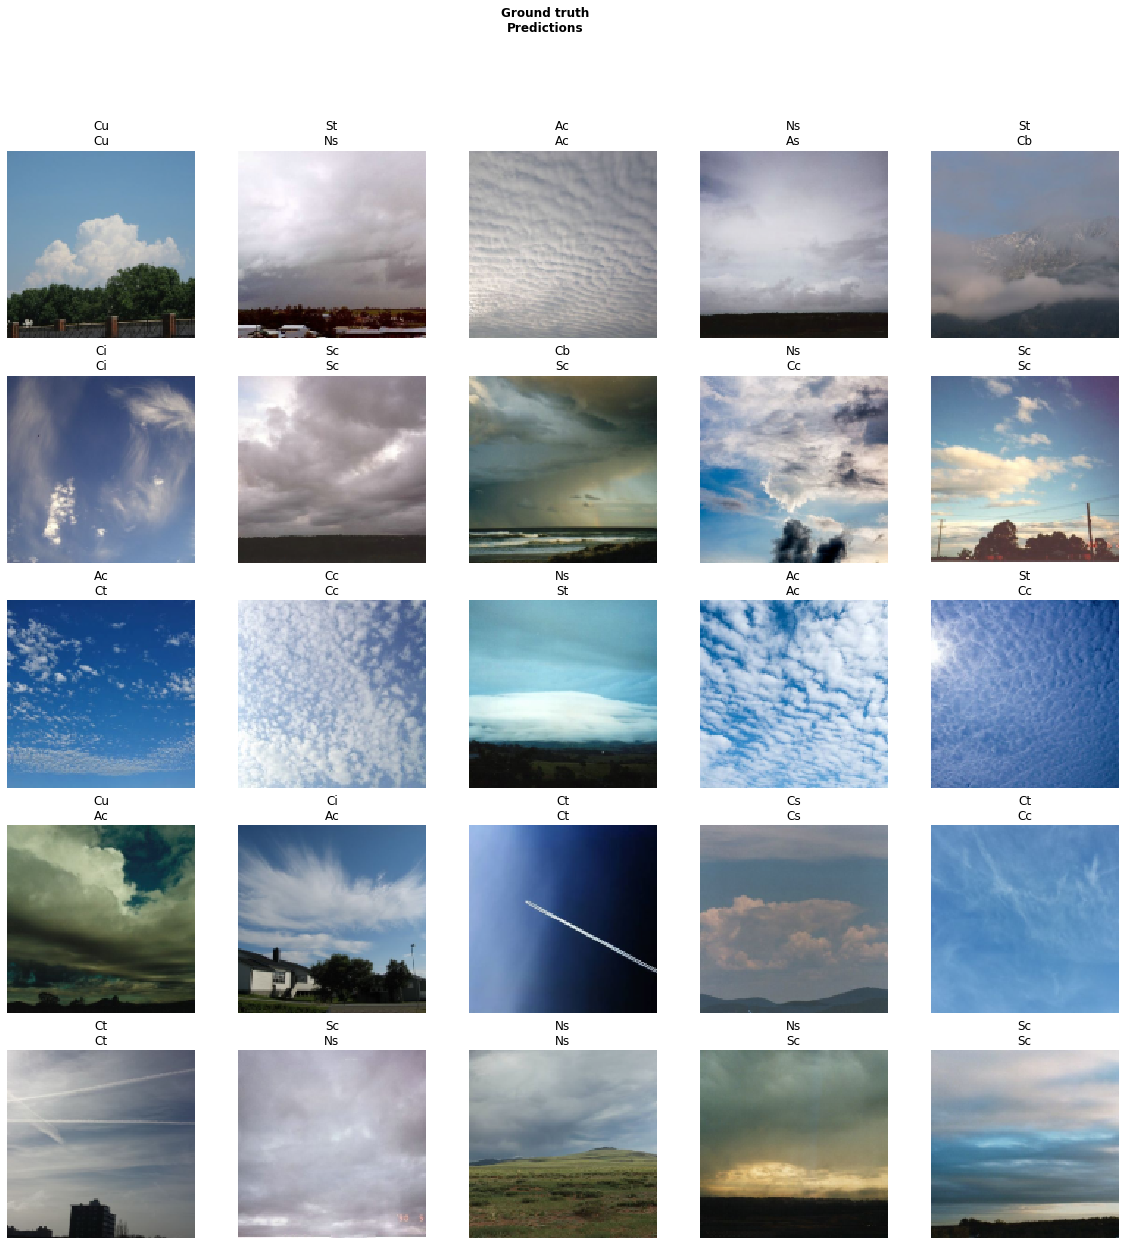

In [28]:
learn.show_results()

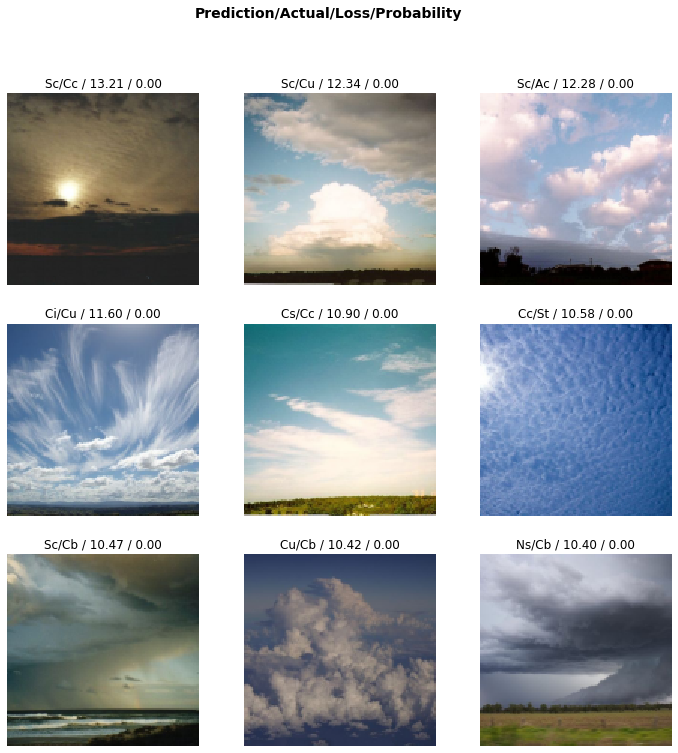

In [29]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_top_losses(9)

In [32]:
learn.predict(open_image('st.JPG'))

(Category Sc,
 tensor(9),
 tensor([0.0498, 0.0370, 0.0021, 0.0007, 0.0030, 0.1229, 0.0020, 0.0013, 0.1750,
         0.5858, 0.0205]))

In [39]:
import torch.onnx
from torch.autograd import Variable
dummy_input = Variable(torch.randn(1, 3, 64, 64)).cuda().half()
torch.onnx.export(learn.model, dummy_input, "model.onnx")

In [44]:
netron.start("model.onnx")


Stopping http://localhost:8080
Serving 'model.onnx' at http://localhost:8080
